# 왜 layer를 deep하게 쌓아야 하나

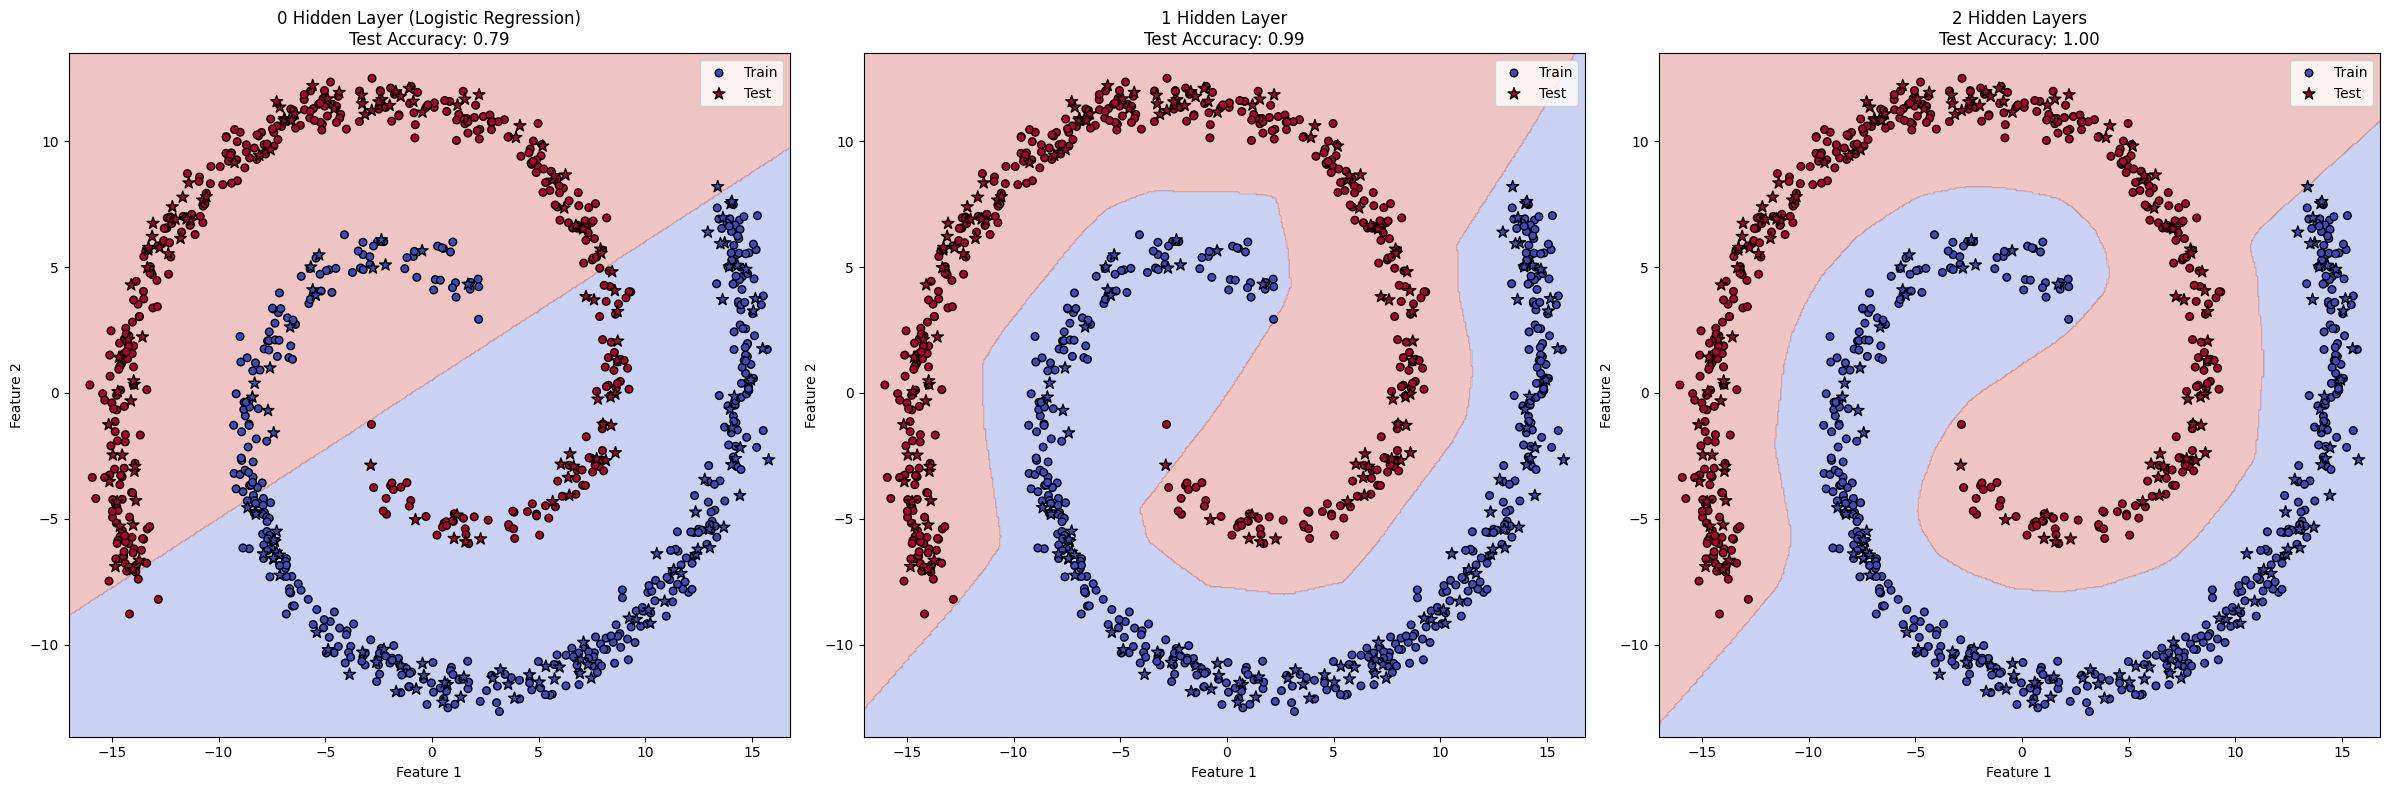

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def generate_two_spirals(n_points, noise=0.5, rotation_angle_degrees=0):
    """
    Generates a two-spiral dataset and applies a rotation by a specified angle.

    Parameters:
        n_points (int): Number of points per spiral.
        noise (float): Standard deviation of Gaussian noise added to the data.
        rotation_angle_degrees (float): Angle in degrees to rotate the data.

    Returns:
        X_rotated (ndarray): Rotated feature matrix of shape (2*n_points, 2).
        y (ndarray): Labels array of shape (2*n_points,).
    """
    np.random.seed(0)  # For reproducibility

    # Generate angles and radii for the first spiral
    theta_a = np.sqrt(np.random.rand(n_points)) * 2 * np.pi
    r_a = 2 * theta_a + np.pi
    data_a = np.vstack((r_a * np.cos(theta_a), r_a * np.sin(theta_a))).T
    data_a += np.random.randn(n_points, 2) * noise  # Add Gaussian noise
    labels_a = np.zeros(n_points)  # Label for the first spiral

    # Generate angles and radii for the second spiral
    theta_b = np.sqrt(np.random.rand(n_points)) * 2 * np.pi
    r_b = -2 * theta_b - np.pi
    data_b = np.vstack((r_b * np.cos(theta_b), r_b * np.sin(theta_b))).T
    data_b += np.random.randn(n_points, 2) * noise  # Add Gaussian noise
    labels_b = np.ones(n_points)  # Label for the second spiral

    # Combine both spirals into a single dataset
    X = np.concatenate((data_a, data_b), axis=0)
    y = np.concatenate((labels_a, labels_b), axis=0)

    # Create the rotation matrix based on the specified angle
    theta_rad = np.deg2rad(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad)]
    ])

    # Apply rotation to the dataset
    X_rotated = X @ rotation_matrix.T

    return X_rotated, y

# Generate the rotated two-spiral dataset
X_rotated, y_rotated = generate_two_spirals(
    n_points=500,
    noise=0.5,
    rotation_angle_degrees=30
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_rotated, y_rotated,
    test_size=0.2,
    random_state=42
)

# Define a list of classifiers with varying complexity
classifiers = [
    MLPClassifier(
        hidden_layer_sizes=(),  # No hidden layers (Logistic Regression)
        activation='logistic',
        max_iter=5000,
        solver='lbfgs',
        random_state=0
    ),
    MLPClassifier(
        hidden_layer_sizes=(100,),  # One hidden layer with 100 neurons
        activation='relu',
        max_iter=5000,
        solver='adam',
        random_state=0
    ),
    MLPClassifier(
        hidden_layer_sizes=(100, 100),  # Two hidden layers with 100 neurons each
        activation='relu',
        max_iter=5000,
        solver='adam',
        random_state=0
    )
]

# Titles corresponding to each classifier for plotting
titles = [
    "0 Hidden Layer (Logistic Regression)",
    "1 Hidden Layer",
    "2 Hidden Layers"
]

# Define color maps for plotting
cmap_light = plt.cm.coolwarm  # Background color map
cmap_bold = ['#FF0000', '#0000FF']  # Colors for the two classes

# Initialize subplots for visualizing decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for clf, ax, title in zip(classifiers, axes.ravel(), titles):
    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)

    # Define the range for the mesh grid
    x_min, x_max = X_rotated[:, 0].min() - 1, X_rotated[:, 0].max() + 1
    y_min, y_max = X_rotated[:, 1].min() - 1, X_rotated[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )

    # Predict class labels for each point in the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary by coloring regions based on predictions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

    # Plot the training data points
    scatter_train = ax.scatter(
        X_train[:, 0], X_train[:, 1],
        c=y_train, edgecolor='k', s=30,
        cmap=plt.cm.coolwarm, label='Train'
    )

    # Plot the testing data points with distinct markers
    scatter_test = ax.scatter(
        X_test[:, 0], X_test[:, 1],
        c=y_test, edgecolor='k', s=80,
        cmap=plt.cm.coolwarm, marker='*', label='Test'
    )

    # Set plot titles and labels
    ax.set_title(f"{title}\nTest Accuracy: {accuracy:.2f}")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Gradient descent로 가중치가 local minima로 간다는게 무슨 뜻일까 -- Loss surface 알아보기

Epoch:    0 Loss: 0.693147
Epoch:   10 Loss: 0.539651
Epoch:   20 Loss: 0.527821
Epoch:   30 Loss: 0.525859
Epoch:   40 Loss: 0.525466
Epoch:   50 Loss: 0.525381
Epoch:   60 Loss: 0.525362
Epoch:   70 Loss: 0.525358
Epoch:   80 Loss: 0.525357
Epoch:   90 Loss: 0.525357
Epoch:  100 Loss: 0.525357


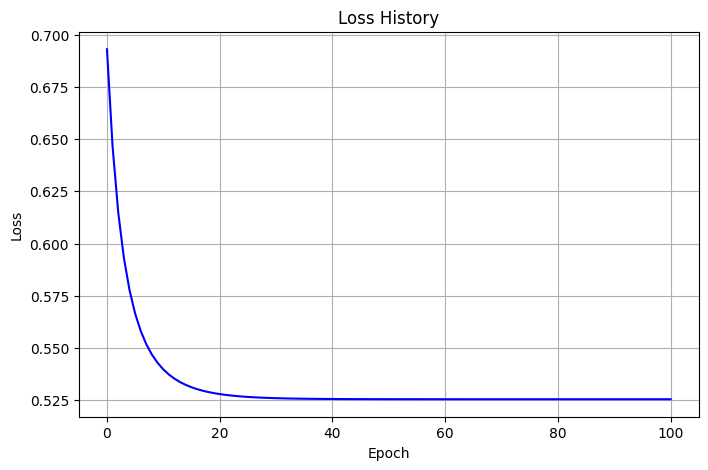

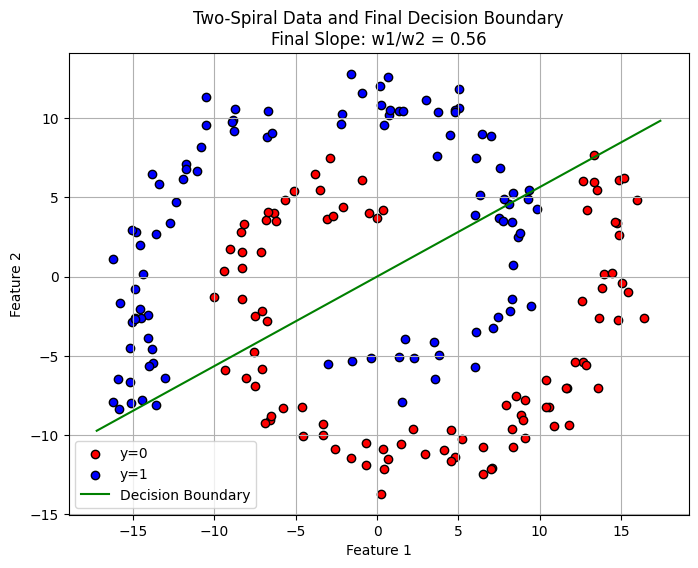

Final Weights:
w1 = -0.0855
w2 = 0.1515
Final Slope: w1/w2 = 0.56


In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

# Generate the two-spiral dataset with specified rotation and noise
n_points = 100          # Number of points per spiral
noise = 1.0             # Standard deviation of Gaussian noise
rotation_angle = 30     # Rotation angle in degrees
X_np, y_np = generate_two_spirals(n_points, noise, rotation_angle_degrees=rotation_angle)

# Convert NumPy arrays to PyTorch tensors with float32 precision
X = torch.FloatTensor(X_np)  # Feature matrix of shape (200, 2)
y = torch.FloatTensor(y_np)  # Labels array of shape (200,)

# Initialize weights for the linear model without bias
W = torch.zeros(2, requires_grad=True)  # Weight vector of shape (2,)

# Set up the optimizer using Stochastic Gradient Descent
learning_rate = 0.01  # Learning rate for the optimizer
optimizer = optim.SGD([W], lr=learning_rate)

# Define training parameters
epochs = 100
loss_history = []       # To record loss at each epoch
weights_history = []    # To record weights at each epoch

# Training loop
for epoch in range(epochs + 1):
    # Compute the linear combination of inputs and weights
    z = X @ W  # Shape: (200,)

    # Apply the sigmoid activation function
    pred = torch.sigmoid(z)

    # Calculate Binary Cross-Entropy Loss
    loss = -(y * torch.log(pred + 1e-7) + (1 - y) * torch.log(1 - pred + 1e-7)).mean()
    loss_history.append(loss.item())
    weights_history.append(W.detach().clone().numpy())

    # Perform backpropagation and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Display loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:4d} Loss: {loss.item():.6f}')

# Plot the loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(epochs + 1), loss_history, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.grid(True)
plt.show()

# Visualize the loss surface using Plotly
# Define a grid around the final weights for visualization
W1_vals = np.linspace(W.detach().numpy()[0] - 5, W.detach().numpy()[0] + 5, 50)
W2_vals = np.linspace(W.detach().numpy()[1] - 5, W.detach().numpy()[1] + 5, 50)
W1_grid, W2_grid = np.meshgrid(W1_vals, W2_vals)
Loss = np.zeros_like(W1_grid)

# Compute loss for each pair of weights on the grid
with torch.no_grad():
    for i in range(W1_grid.shape[0]):
        for j in range(W1_grid.shape[1]):
            w = torch.tensor([W1_grid[i, j], W2_grid[i, j]], dtype=torch.float32)
            z = X @ w
            pred = torch.sigmoid(z)
            loss_ij = -(y * torch.log(pred + 1e-7) + (1 - y) * torch.log(1 - pred + 1e-7)).mean()
            Loss[i, j] = loss_ij.item()

# Create an interactive 3D surface plot of the loss landscape
fig = go.Figure(data=[go.Surface(z=Loss, x=W1_grid, y=W2_grid, colorscale='Viridis', opacity=0.8)])
fig.update_layout(
    title='Loss Surface',
    scene=dict(
        xaxis_title='w1',
        yaxis_title='w2',
        zaxis_title='Loss'
    ),
    autosize=False,
    width=800,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.show()

# Create an animated visualization of the decision boundary evolution
frames = []
for idx, (w1, w2) in enumerate(weights_history):
    # Define the decision boundary based on current weights
    if w2 != 0:
        x_vals = np.linspace(X_np[:,0].min()-1, X_np[:,0].max()+1, 100)
        y_vals = - (w1 * x_vals) / w2
        slope = -w1 / w2
        slope_text = f"Slope (m) = {slope:.2f}"
    else:
        x_vals = np.full(100, 0)
        y_vals = np.linspace(X_np[:,1].min()-1, X_np[:,1].max()+1, 100)
        slope_text = "Slope (m) = ∞"

    # Create a frame for each epoch
    frame = go.Frame(
        data=[
            go.Scatter(
                x=X_np[y_np == 0, 0],
                y=X_np[y_np == 0, 1],
                mode='markers',
                marker=dict(color='red', size=5, line=dict(width=1, color='black')),
                name='Class 0'
            ),
            go.Scatter(
                x=X_np[y_np == 1, 0],
                y=X_np[y_np == 1, 1],
                mode='markers',
                marker=dict(color='blue', size=5, line=dict(width=1, color='black')),
                name='Class 1'
            ),
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                line=dict(color='green', width=2),
                name='Decision Boundary'
            )
        ],
        layout=go.Layout(
            annotations=[
                dict(
                    x=0.5,
                    y=1.05,
                    xref="paper",
                    yref="paper",
                    showarrow=False,
                    text=f"Epoch: {idx}, {slope_text}",
                    font=dict(size=12)
                )
            ]
        ),
        name=str(idx)
    )
    frames.append(frame)

# Set up the initial state of the animated plot
initial_w1, initial_w2 = weights_history[0]
if initial_w2 != 0:
    x_vals_init = np.linspace(X_np[:,0].min()-1, X_np[:,0].max()+1, 100)
    y_vals_init = - (initial_w1 * x_vals_init) / initial_w2
    initial_slope = -initial_w1 / initial_w2
    slope_text_init = f"Slope (m) = {initial_slope:.2f}"
else:
    x_vals_init = np.full(100, 0)
    y_vals_init = np.linspace(X_np[:,1].min()-1, X_np[:,1].max()+1, 100)
    slope_text_init = "Slope (m) = ∞"

# Create the figure for the animated decision boundary
fig_decision = go.Figure(
    data=[
        go.Scatter(
            x=X_np[y_np == 0, 0],
            y=X_np[y_np == 0, 1],
            mode='markers',
            marker=dict(color='red', size=5, line=dict(width=1, color='black')),
            name='Class 0'
        ),
        go.Scatter(
            x=X_np[y_np == 1, 0],
            y=X_np[y_np == 1, 1],
            mode='markers',
            marker=dict(color='blue', size=5, line=dict(width=1, color='black')),
            name='Class 1'
        ),
        go.Scatter(
            x=x_vals_init,
            y=y_vals_init,
            mode='lines',
            line=dict(color='green', width=2),
            name='Decision Boundary'
        )
    ],
    layout=go.Layout(
        title="Decision Boundary Evolution During Training",
        xaxis=dict(range=[X_np[:,0].min()-1, X_np[:,0].max()+1], title='Feature 1'),
        yaxis=dict(range=[X_np[:,1].min()-1, X_np[:,1].max()+1], title='Feature 2'),
        annotations=[
            dict(
                x=0.5,
                y=1.05,
                xref="paper",
                yref="paper",
                showarrow=False,
                text=f"Epoch: 0, {slope_text_init}",
                font=dict(size=12)
            )
        ],
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(
                label="Play",
                method="animate",
                args=[None, {
                    "frame": {"duration": 50, "redraw": True},
                    "fromcurrent": True,
                    "transition": {"duration": 0}
                }]
            )]
        )]
    ),
    frames=frames
)

# Display the animated decision boundary
fig_decision.show()

# Plot the final decision boundary along with the data points
W_final = W.detach().numpy()
x1_np = X[:, 0].detach().numpy()
x2_np = X[:, 1].detach().numpy()
y_np = y.detach().numpy()

# Determine the slope of the final decision boundary
if W_final[1] != 0:
    final_slope = -W_final[0] / W_final[1]
    slope_text_final = f"Final Slope: w1/w2 = {final_slope:.2f}"
else:
    final_slope = np.inf
    slope_text_final = "Final Slope: w1/w2 = ∞"

# Create a scatter plot of the dataset with the final decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(x1_np[y_np == 0], x2_np[y_np == 0], color='red', label='y=0', edgecolor='black')
plt.scatter(x1_np[y_np == 1], x2_np[y_np == 1], color='blue', label='y=1', edgecolor='black')

# Plot the decision boundary
if W_final[1] != 0:
    x1_boundary = np.linspace(x1_np.min() - 1, x1_np.max() + 1, 200)
    x2_boundary = - (W_final[0] * x1_boundary) / W_final[1]
    plt.plot(x1_boundary, x2_boundary, color='green', label='Decision Boundary')
else:
    # If w2 is zero, the decision boundary is a vertical line
    x1_boundary = 0  # Since w1*x1 + 0*x2 = 0 implies x1=0
    plt.axvline(x=x1_boundary, color='green', label='Decision Boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Two-Spiral Data and Final Decision Boundary\n{slope_text_final}')
plt.legend()
plt.grid(True)
plt.show()

# Display the final weights and slope
print(f'Final Weights:\nw1 = {W_final[0]:.4f}\nw2 = {W_final[1]:.4f}')
print(f'{slope_text_final}')


# 파이토치에서 forward pass와 backprop은 어떻게 구현되는가

In [3]:
import torch
import torch.optim as optim
import numpy as np

n_points = 100
noise = 1.0
rotation_angle = 30

X_np, y_np = generate_two_spirals(n_points, noise, rotation_angle_degrees=rotation_angle)

# 여기가 데이터입니다
X = torch.FloatTensor(X_np) # 200개의 데이터포인트에 대해 Feature 1과 Feature 2의 2차원 정보가 있겠죠? 그럼 행렬의 사이즈는? --> (200, 2)
y = torch.FloatTensor(y_np) # 200개의 데이터포인트에 대해 0 또는 1의 레이블이 있겠죠? 그럼 행렬의 사이즈는? --> (200,)

# 여기가 가중치입니다
W = torch.zeros(2, requires_grad=True) # (z = w1 * x1 + w2 * x2)이니까 W에는 w1과 w2가 필요하겠죠? 그럼 행렬의 사이즈는? --> (2,)

learning_rate = 0.01
optimizer = optim.SGD([W], lr=learning_rate)

epochs = 100

# 100번 반복합시다
for epoch in range(epochs + 1):

    z = X @ W # 200개의 데이터포인트에 대해 행렬연산을 해줍시다. 아웃풋 행렬의 사이즈는? --> (200,)

    # 여기가 pred입니다. 이러면 forward pass를 한 번 한거죠.
    pred = torch.sigmoid(z) # 200개의 데이터포인트에 대해 시그모이드 함수를 통과시켜줍시다

    # 여기가 loss function입니다
    loss = -(y * torch.log(pred + 1e-7) + (1 - y) * torch.log(1 - pred + 1e-7)).mean() # 200개의 prediction에 대한 loss의 평균값

    # 여기가 backprop입니다. 파이토치에서는,
    optimizer.zero_grad()  # 이전 epoch의 gradient(즉, dL/dw)를 리셋시켜 주는 과정이 필요합니다
    loss.backward()        # 이렇게 gradient를 계산하고,
    optimizer.step()       # weight들을 gradient를 이용해 업데이트 시켜줍니다

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:4d} Loss: {loss.item():.6f}')

W_final = W.detach().numpy()

if W_final[1] != 0:
    final_slope = -W_final[0] / W_final[1]
    slope_text_final = f"Final Slope: w1/w2 = {final_slope:.2f}"
else:
    final_slope = np.inf
    slope_text_final = "Final Slope: w1/w2 = ∞"

print(f'\nFinal Weights:\nw1 = {W_final[0]:.4f}\nw2 = {W_final[1]:.4f}')
print(f'{slope_text_final}')


Epoch:    0 Loss: 0.693147
Epoch:   10 Loss: 0.539651
Epoch:   20 Loss: 0.527821
Epoch:   30 Loss: 0.525859
Epoch:   40 Loss: 0.525466
Epoch:   50 Loss: 0.525381
Epoch:   60 Loss: 0.525362
Epoch:   70 Loss: 0.525358
Epoch:   80 Loss: 0.525357
Epoch:   90 Loss: 0.525357
Epoch:  100 Loss: 0.525357

Final Weights:
w1 = -0.0855
w2 = 0.1515
Final Slope: w1/w2 = 0.56


# MNIST classification을 구현해봅시다

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mnist_train = datasets.MNIST(root=".",
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

mnist_test = datasets.MNIST(root=".",
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True)

batch_size = 100
dataloader = DataLoader(dataset=mnist_train,
                       batch_size=batch_size,
                       shuffle=True,
                       drop_last=True)

X, y = next(iter(dataloader))
print(X.shape)
print(y.shape)

cpu
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.57MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(28*28, 50, bias=False),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(50, 10, bias=False),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.layer1(x)
        x = self.layer2(x)

        return x

model = Model()
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=False)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=False)
  )
)


In [6]:
summary(model, input_size=(100, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,200
       BatchNorm1d-2                   [-1, 50]             100
              ReLU-3                   [-1, 50]               0
           Dropout-4                   [-1, 50]               0
            Linear-5                   [-1, 10]             500
Total params: 39,800
Trainable params: 39,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.30
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


In [7]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 20
for epoch in range(epochs + 1):

    avg_loss = 0
    total_batch = len(dataloader)

    for X, y in dataloader:
        X = X.view(-1, 28*28).to(device)
        y = y.to(device)

        pred = model(X)

        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss / total_batch

    print(f'Epoch: {epoch:4d} Loss: {avg_loss:.6f}')

Epoch:    0 Loss: 0.576468
Epoch:    1 Loss: 0.422581
Epoch:    2 Loss: 0.382314
Epoch:    3 Loss: 0.353502
Epoch:    4 Loss: 0.337834
Epoch:    5 Loss: 0.328706
Epoch:    6 Loss: 0.314913
Epoch:    7 Loss: 0.308853
Epoch:    8 Loss: 0.305275
Epoch:    9 Loss: 0.292859
Epoch:   10 Loss: 0.289850
Epoch:   11 Loss: 0.290885
Epoch:   12 Loss: 0.282436
Epoch:   13 Loss: 0.281112
Epoch:   14 Loss: 0.279292
Epoch:   15 Loss: 0.273606
Epoch:   16 Loss: 0.275605
Epoch:   17 Loss: 0.268160
Epoch:   18 Loss: 0.268079
Epoch:   19 Loss: 0.266656
Epoch:   20 Loss: 0.265150


y: 7
pred: 7


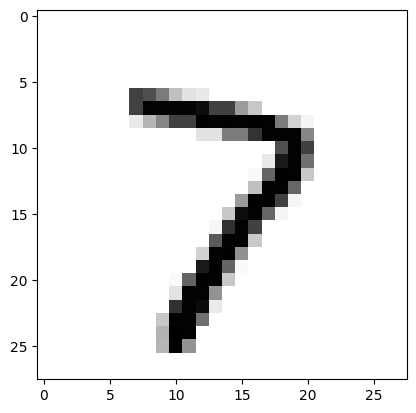

In [8]:
model.eval()

with torch.no_grad():
    r = random.randint(0, len(mnist_test) - 1)
    X_random = mnist_test.data[r:r+1].view(-1, 28*28).float().to(device)
    y_random = mnist_test.targets[r:r+1].to(device)

    pred = model(X_random)

    print(f"y: {y_random.item()}")
    print(f"pred: {torch.argmax(pred, 1).item()}")
    plt.imshow(mnist_test.data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()


In [9]:
model.eval()

with torch.no_grad():
    X_test = mnist_test.data.view(-1, 28*28).float().to(device)
    y_test = mnist_test.targets.to(device)

    prediction = model(X_test)

    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()

    num_correct = correct_prediction.sum().item()
    total = len(y_test)

    print(f"Correct Predictions: {num_correct} / {total}")
    print(f"Accuracy: {accuracy.item():.4f}")


Correct Predictions: 8757 / 10000
Accuracy: 0.8757


# 과제: Hyperparameter tuning을 통해 accuracy를 높여봅시다!

- layer의 갯수
- layer 당 뉴런의 갯수
- activation function의 종류
- optimizer의 종류
- batch의 size
- dropout ratio의 크기
- learning rate의 크기
- epoch의 횟수

이 파일의 위치: www.github.com/star-bits/sogangparrot